<a href="https://colab.research.google.com/github/Firojpaudel/Deepseek_implementation_scratch/blob/main/MHA_vizualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Approach 1: First I'll try to hardcode using 2 heads with an toy example

In [11]:
%pip install -qq matplotlib networkx

Vocabulary: {'the': 0, 'cat': 1, 'sat': 2, 'on': 3, 'mat': 4}
Input shape: torch.Size([6, 8]) -> 6 tokens, each 8-dim

Head 0:
 Q shape: torch.Size([6, 4])
 K shape: torch.Size([6, 4])
 V shape: torch.Size([6, 4])
 Scores shape: torch.Size([6, 6])
 Weights shape: torch.Size([6, 6])
 Head output shape: torch.Size([6, 4])

Head 1:
 Q shape: torch.Size([6, 4])
 K shape: torch.Size([6, 4])
 V shape: torch.Size([6, 4])
 Scores shape: torch.Size([6, 6])
 Weights shape: torch.Size([6, 6])
 Head output shape: torch.Size([6, 4])

Concatenated shape: torch.Size([6, 8])
Final output shape: torch.Size([6, 8])


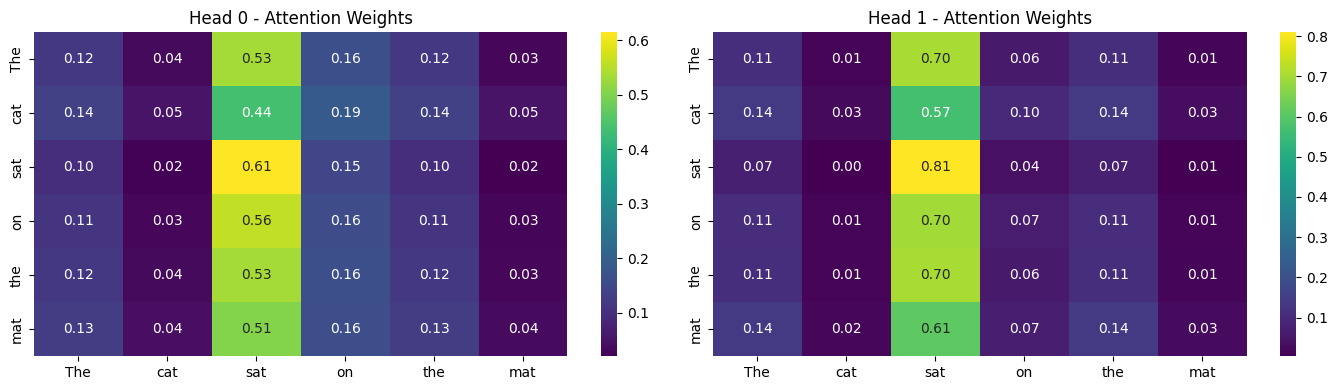

In [29]:
#@ Imports
import torch
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt


#!! Settings

sentence = ["The", "cat", "sat", "on", "the", "mat"]
L = len(sentence)   # number of tokens
d_model = 8         # model dimension
h = 2               # number of heads
d_k = d_model // h  # dimension per head

torch.manual_seed(0)


#@ Step 1: Embeddings

# Build vocab directly from sentence order (preserves duplicates)
unique_words = list(dict.fromkeys([w.lower() for w in sentence]))  # keep order, remove duplicates
vocab = {word: idx for idx, word in enumerate(unique_words)}

embedding_matrix = torch.rand(len(vocab), d_model)

# Convert sentence into embeddings
X = torch.stack([embedding_matrix[vocab[word.lower()]] for word in sentence])
print(f"Vocabulary: {vocab}")
print(f"Input shape: {X.shape} -> {L} tokens, each {d_model}-dim")


#@ Step 2: Define Attention Weights

# Separate projection matrices per head
W_Q = torch.rand(h, d_model, d_k)
W_K = torch.rand(h, d_model, d_k)
W_V = torch.rand(h, d_model, d_k)

intermediate = {"Q": {}, "K": {}, "V": {}, "scores": {}, "weights": {}, "head_out": {}}
heads_output = []


#@ Step 3: Attention per Head

for i in range(h):
    # Linear projections
    Q = X @ W_Q[i]   # [L, d_k]
    K = X @ W_K[i]   # [L, d_k]
    V = X @ W_V[i]   # [L, d_k]

    # Attention scores and weights
    scores = Q @ K.T / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))  # [L, L]
    weights = F.softmax(scores, dim=-1)  # [L, L]

    # Weighted sum of values
    head_out = weights @ V  # [L, d_k]

    # Store results
    intermediate["Q"][i], intermediate["K"][i], intermediate["V"][i] = Q, K, V
    intermediate["scores"][i], intermediate["weights"][i], intermediate["head_out"][i] = scores, weights, head_out
    heads_output.append(head_out)

    print(f"\nHead {i}:")
    print(" Q shape:", Q.shape)
    print(" K shape:", K.shape)
    print(" V shape:", V.shape)
    print(" Scores shape:", scores.shape)
    print(" Weights shape:", weights.shape)
    print(" Head output shape:", head_out.shape)


#@ Step 4: Concatenate Heads

concat = torch.cat(heads_output, dim=-1)  # [L, h*d_k] = [L, d_model]
print("\nConcatenated shape:", concat.shape)

# Final projection (shared across heads)
W_O = torch.rand(d_model, d_model)
final_output = concat @ W_O
print("Final output shape:", final_output.shape)

intermediate["concat"], intermediate["final_output"] = concat, final_output


#@ Step 5: Visualization

fig, axes = plt.subplots(1, h, figsize=(14, 4))
for i in range(h):
    sns.heatmap(intermediate["weights"][i].detach().numpy(),
                xticklabels=sentence, yticklabels=sentence,
                cmap="viridis", annot=True, fmt=".2f", ax=axes[i])
    axes[i].set_title(f"Head {i} - Attention Weights")
plt.tight_layout()
plt.show()

### Approach 2: Visualizing using BertViz

In [31]:
%pip install -qq transformers bertviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.8 MB/s eta 0:00:00


In [33]:
#@ Imports
from transformers import BertTokenizer, BertModel
from bertviz import head_view, model_view
import torch

#@ Load BERT + tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_attentions=True)

#@ Encode sentence
sentence = "The cat sat on the mat"
inputs = tokenizer(sentence, return_tensors='pt')
outputs = model(**inputs)

# Extract attention
attentions = outputs.attentions  # (num_layers, batch, num_heads, seq_len, seq_len)

# Convert input_ids to tokens
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

#@ Visualize
head_view(attentions, tokens)   # Explore per-head attention
model_view(attentions, tokens)  # Explore all layers & heads

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

> Note: The visualization using `BertViz` might not render in GitHub since its interactive